In [1]:
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as graph
from pandas.plotting import scatter_matrix

graph.style.use('fivethirtyeight')

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Howell1.csv', sep=';')
df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


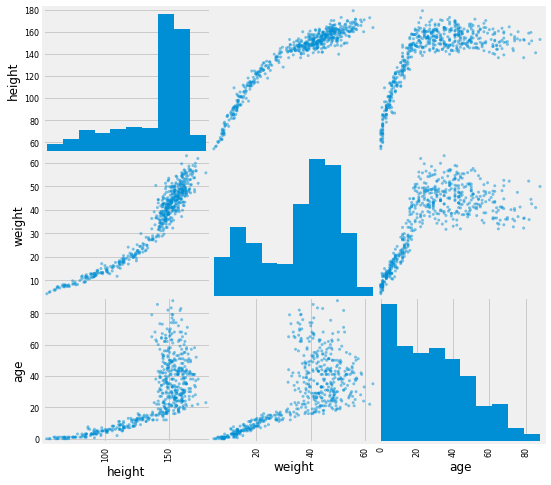

In [3]:
numerical_cols = ['height', 'weight', 'age']

scatter_matrix(df[numerical_cols], figsize=(8, 8))
graph.show()

Let's look at just the adults since height and weight are highly correlated with age

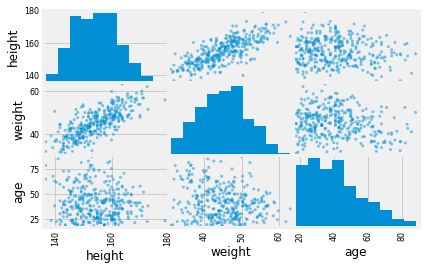

In [4]:
df = df.query('age >= 18')

scatter_matrix(df[numerical_cols])
graph.show()

## Learning parameters of height in the data

We will model height using a normal distribution - the observed heights are sampled from a normal distribution described by:

#### ${h_i \sim \mathcal{N}(\mu_i, \sigma}$)

Using the priors: 

#### ${\mu = \mathcal{N}(178, 20)}$

#### ${\sigma = Uniform(0, 50)}$

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, mu]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:10<00:00, 1920.20draws/s]
/home/harshil/miniconda3/envs/pymc3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


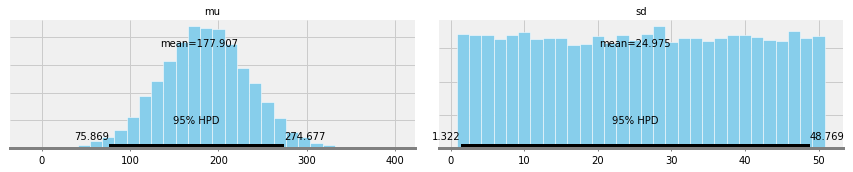

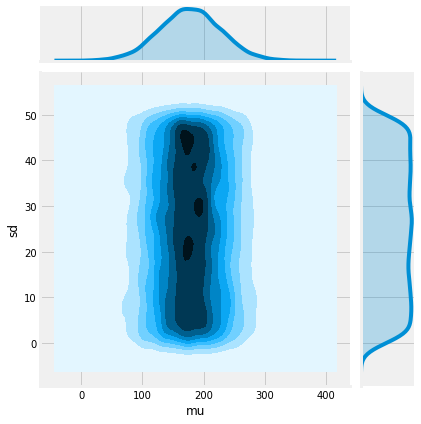

In [5]:
with pm.Model() as model:
    # Priors
    mu = pm.Normal('mu', 178, 50)
    sd = pm.Uniform('sd', 0, 50)
    
    # Sample
    trace = pm.sample(draws=10000)
    trace_df = pm.trace_to_dataframe(trace)
    
    # Plot prior
    pm.plot_posterior(trace)
    
    # Plot joint prior probability
    sns.jointplot(trace_df['mu'], trace_df['sd'], kind='kde')
    graph.show()

The prior probability is spread out - lets see how the data changes this

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, mu]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:14<00:00, 1486.72draws/s]
The acceptance probability does not match the target. It is 0.8899346970724277, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8797318240795711, but should be close to 0.8. Try to increase the number of tuning steps.


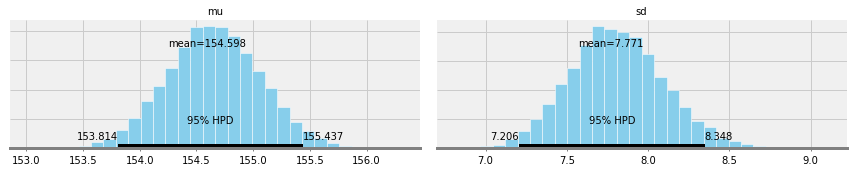

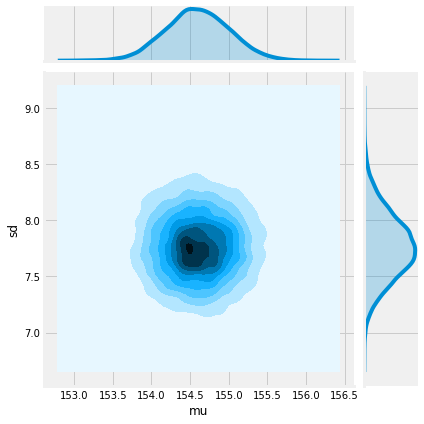

In [7]:
with pm.Model() as model:
    # Priors
    mu = pm.Normal('mu', 178, 50)
    sd = pm.Uniform('sd', 0, 50)
    
    # Likelihood
    observed = pm.Normal('observed', mu=mu, sd=sd, observed=df['height'])
    
    # Sample
    trace = pm.sample(draws=10000)
    trace_df = pm.trace_to_dataframe(trace)
    
    # Posterior
    pm.plot_posterior(trace)
    
    # Plot posterior joint density
    sns.jointplot(trace_df['mu'], trace_df['sd'], kind='kde')
    graph.show()

Compared to the prior probability the posterior probability is much narrower 

The mean height is 154.5cm with a standard deviation of 7.8

## Modeling height using weight

From the pairplot above we can see a relationship between weight and height - let's try to infer the parameters of this relationship

Here the observed height is still sampled from a normal described by:

#### ${h_i = \mathcal{N}(\mu_i, \sigma}$)

However, the mean of the normal distribution varies with the weight. So the height of an individual i is sampled from a normal distribution who's mean is influenced by the weight like so:

#### ${\mu_i = \alpha + \beta * weight_i}$

#### Priors 

#### ${\alpha = \mathcal{N}(178, 100)}$

#### ${\beta = \mathcal{N}(0, 10)}$

#### ${\sigma = Uniform(0, 50)}$

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, beta, alpha]
Sampling 2 chains: 100%|██████████| 21000/21000 [01:02<00:00, 333.80draws/s]
The acceptance probability does not match the target. It is 0.8937428066492262, but should be close to 0.8. Try to increase the number of tuning steps.


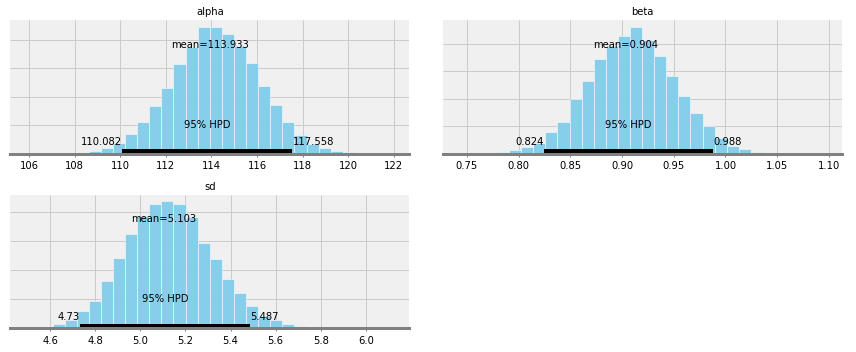

In [8]:
with pm.Model() as model:
    # Priors
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sd = pm.Uniform('sd', 0, 50)
    
    # Linear relationship
    mu = alpha + beta * df['weight']
    
    # Likelihood
    observed = pm.Normal('observed', mu=mu, sd=sd, observed=df['height'])
    
    # Sample
    trace = pm.sample(draws=10000)
    trace_df = pm.trace_to_dataframe(trace)
    
    # Posterior
    pm.plot_posterior(trace)
    graph.show()

The alpha parameter tells us what the height of an individual with zero weight would be. This is pretty nonsensical but there is a way to make the alpha parameter more interpretable which we will look at below.

The beta parameter tells us how weight is related to height. A 1kg increase in weight results in a 0.91 cm increase in height. The posterior density of beta is largest between 0.80 and 1.00 so we are fairly certain about the strenght of the weight and height relationship. 

Notice also the sd parameter for the distribution of height has decreased when weight is used as a predictor. This is likely some of the variance in height was explained away by the weight. 

We can visualize the linear relationship between weight and height along with its uncertainty by plotting lines using samples from the posterior distribution

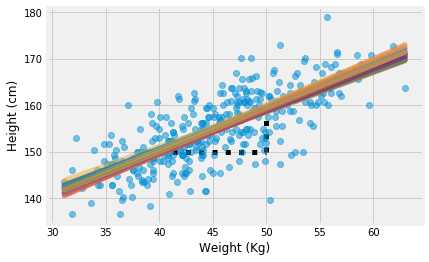

In [9]:
graph.plot(df['weight'], df['height'], 'o', alpha=0.5)

for i, row in trace_df.sample(50).iterrows():
    height_pred = row['alpha'] + df['weight'] * row['beta'] 
    graph.plot(df['weight'], height_pred, alpha=0.5)
    
graph.vlines(x=50, ymin=150, ymax=160, linestyle='dotted', color='black', linewidth=5)
graph.hlines(y=150, xmin=40, xmax=50, linestyle='dotted', color='black', linewidth=5)
graph.xlabel('Weight (Kg)')
graph.ylabel('Height (cm)')
graph.show()

By following the dotted black line we can see that a 10kg increase in weight leads to slightly less than 10cm of increase in height

Okay, back to the confusing alpha parameter. If we transform the weights by subtracting each weight value from the mean then the zero weight value will be the mean weight value. This way the alpha parameter can be interpreted as what the height is for an average weighted person. The beta parameter will then be interpreted as the change in height from an average weighted person as the weight changes.

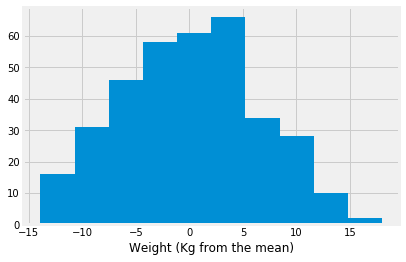

In [10]:
df['transformed_weight'] = df['weight'] - df['weight'].mean()

graph.hist(df['transformed_weight'])
graph.xlabel('Weight (Kg from the mean)')
graph.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, beta, alpha]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:19<00:00, 1052.17draws/s]


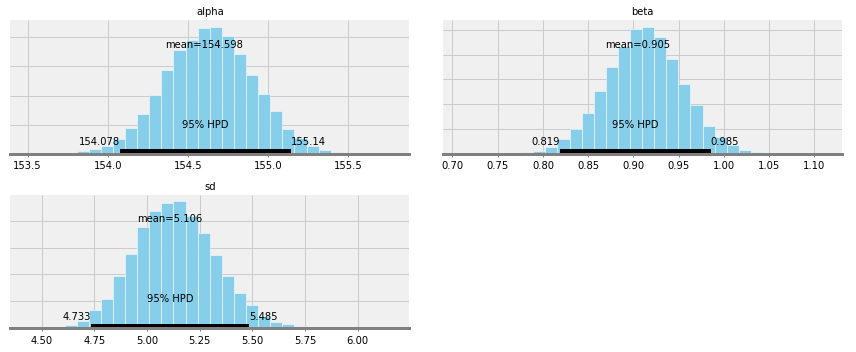

In [11]:
# Rerun model with transformed height 

with pm.Model() as model:
    # Priors
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sd = pm.Uniform('sd', 0, 50)
    
    # Linear relationship
    mu = alpha + beta * df['transformed_weight']
    
    # Likelihood
    observed = pm.Normal('observed', mu=mu, sd=sd, observed=df['height'])
    
    # Sample
    trace = pm.sample(draws=10000)
    trace_df = pm.trace_to_dataframe(trace)
    
    # Posterior
    pm.plot_posterior(trace)
    graph.show()

the highest density for alpha is between 154 to 155, which is the distribution of possible heights for an average weighted person. Alpha therefore means the expected value of the outcome when the predictor is at its average value, which is much easier to interpret.

The transformation had no effect on beta and sd.

We can easily see that alpha is the expected height when the weight is average (zero on the transformed scale) using this graph

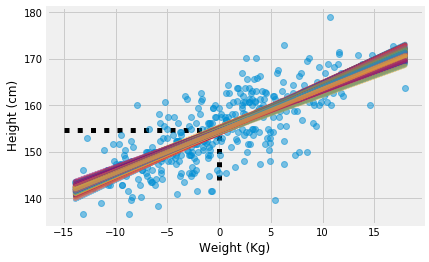

In [12]:
graph.plot(df['transformed_weight'], df['height'], 'o', alpha=0.5)

for i, row in trace_df.sample(500).iterrows():
    height_pred = row['alpha'] + df['transformed_weight'] * row['beta'] 
    graph.plot(df['transformed_weight'], height_pred, alpha=0.5)

mean_height = trace_df['alpha'].mean()
graph.vlines(x=0, ymin=144, ymax=mean_height, linestyle='dotted', color='black', linewidth=5)
graph.hlines(y=mean_height, xmin=-15, xmax=0, linestyle='dotted', color='black', linewidth=5)

graph.xlabel('Weight (Kg)')
graph.ylabel('Height (cm)')
graph.show()

We can also make predictions of an individuals height given their weight. The beauty of having posterior samples is we can also get the uncertainty in our predictions.

/home/harshil/miniconda3/envs/pymc3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


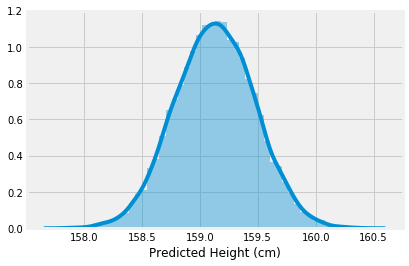

In [13]:
weight = 50
transformed_weight = weight - df['weight'].mean()

predicted_heights = trace_df['alpha'] + trace_df['beta'] * transformed_weight

sns.distplot(predicted_heights)
graph.xlabel('Predicted Height (cm)')
graph.show()

Lets predict the heights of ten individuals with varying weight

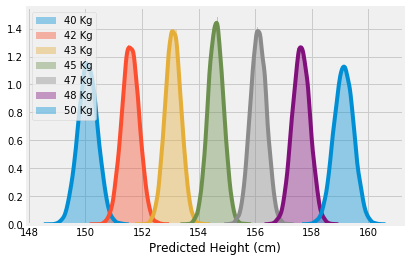

In [14]:
weights = np.linspace(40, 50, 7)

for weight in weights:
    transformed_weight = weight - df['weight'].mean()

    predicted_heights = trace_df['alpha'] + trace_df['beta'] * transformed_weight

    sns.distplot(predicted_heights, label=f'{weight:.0f} Kg')
    graph.xlabel('Predicted Height (cm)')

graph.legend()
graph.show()

Interestingly we can see the distributions get taller in the middle than on the edges, this is because the middle distributions are narrower due to the model having more data associated with weights in that region

There is nothing stopping us from making these height predictons for every single weight we have observed so lets do that and plot it

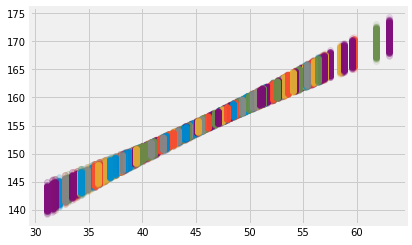

In [15]:
for idx, weight in enumerate(df['weight']):
    transformed_weight = weight - df['weight'].mean()
    predicted_heights = trace_df['alpha'] + trace_df['beta'] * transformed_weight
    
    graph.plot([weight] * len(predicted_heights), predicted_heights, 'o', alpha=0.1)
    
graph.show()

Again we see the same phenomenon of the uncertainty in heights being less where we have more data (the center portion of the line)